In [1]:
import os
import sys
from tqdm import tqdm,tnrange
import time
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from music21 import *
#from utilities.constants import *
#from utilities.utilities import *

WORKING_DIR = os.path.abspath("")
SCORES_DIR = os.path.join(WORKING_DIR,"scores")
DIRECTION = "asc"
DISTANCE_TH = 3

# Organise files in documents

In [2]:
def get_all_pitchclassdistribution_df(path, direction = "all", distance_th = 2):
    
    number_of_files = int(sum(1 for _ in os.listdir(path)))

    pitchclass_df = pd.DataFrame()
    
    for score,i in zip(os.listdir(path),tnrange(number_of_files-1)):
        
        _, extension = os.path.splitext(score)
        
        if extension == ".xml":
            
            s = converter.parse(os.path.join(path,score))
            
            classes,percentage = get_pitch_class_percentage(s, direction, distance_th)
            
            classes = [str(x) for x in classes]
            percentage = [[100*x] for x in percentage]
            
            tmp_df = pd.DataFrame(dict(zip(classes,percentage)))
            pitchclass_df = pd.concat([pitchclass_df,tmp_df],sort = True, ignore_index = True)
            
    return pitchclass_df


In [3]:
def get_pitch_class_percentage(score, direction, distance_th):
    #directions asc = ascendant, desc = descendant, all
    
    pitches = score.parts[0].pitches
    
    count_pitch_classes = defaultdict(int)
    
    midi_pitches = select_pitches_direction(pitches, direction,distance_th)
    
    for note in midi_pitches:
        count_pitch_classes[int(note%12)] += 1
        
    classes = sorted(list(count_pitch_classes.keys()))
    data = []
    for c in classes:
        data.append(count_pitch_classes[c])
    
    data = np.array(data)/sum(data)
    
    return classes, data

In [4]:
def select_pitches_direction(pitches,direction,distance_th):
    if not direction in ["all","desc","asc"]:
        raise ValueError('Only all, desc, asc modes accepted')
    if distance_th<=0:
        raise ValueError('distance_th must be ≥1')
    if direction == "all":
        return [note.ps for note in pitches]

    midi_pitches = np.array([p.ps for p in pitches])
    difference = np.diff(midi_pitches)
    difference = np.clip(difference, a_min = -1, a_max = 1)
    
    state = "null"
    selection = []
    
    for i in range(len(midi_pitches)):
    
        suma = sum(difference[i:(i+distance_th)])
        if suma == distance_th:
            state = "asc"
        elif suma == -1*distance_th:
            state = "desc"
        
        if state == "asc" and state == direction:
            selection.append(midi_pitches[i])
        elif state == "desc" and state == direction:
            selection.append(midi_pitches[i])
        
        #print(str(midi_pitches[i]) + "," + str(difference[i]) + " suma:" + str(suma) + "state:" + state)
    
    return selection

In [5]:
pitchclass_df = get_all_pitchclassdistribution_df(SCORES_DIR, DIRECTION, distance_th = DISTANCE_TH)

In [6]:
pitchclass_df = pitchclass_df.transpose()
pitchclass_df.index = pitchclass_df.index.astype(int)
pitchclass_df = pitchclass_df.sort_index().transpose().replace(np.nan, 0)
pitchclass_df.head()

0    1          2    3          4          5          6          7   \
0  15.535568  0.0  13.082584  0.0   8.094849  23.303352   0.000000  17.007359   
1  13.807983  0.0  12.513484  0.0  10.248112  22.869471   0.000000  12.081985   
2  17.743403  0.0  15.741583  0.0  17.925387  12.556870   0.000000  17.015469   
3  11.396304  0.0  13.655031  0.0  18.788501  16.529774   0.821355  21.457906   
4  11.498973  0.0  12.320329  0.0  24.127310   2.361396  11.498973  19.917864   

    8          9         10        11  
0  0.0  14.963205   0.00000  8.013083  
1  0.0  16.289105  12.18986  0.000000  
2  0.0  10.555050   0.00000  8.462238  
3  0.0   9.958932   0.00000  7.392197  
4  0.0  18.275154   0.00000  0.000000

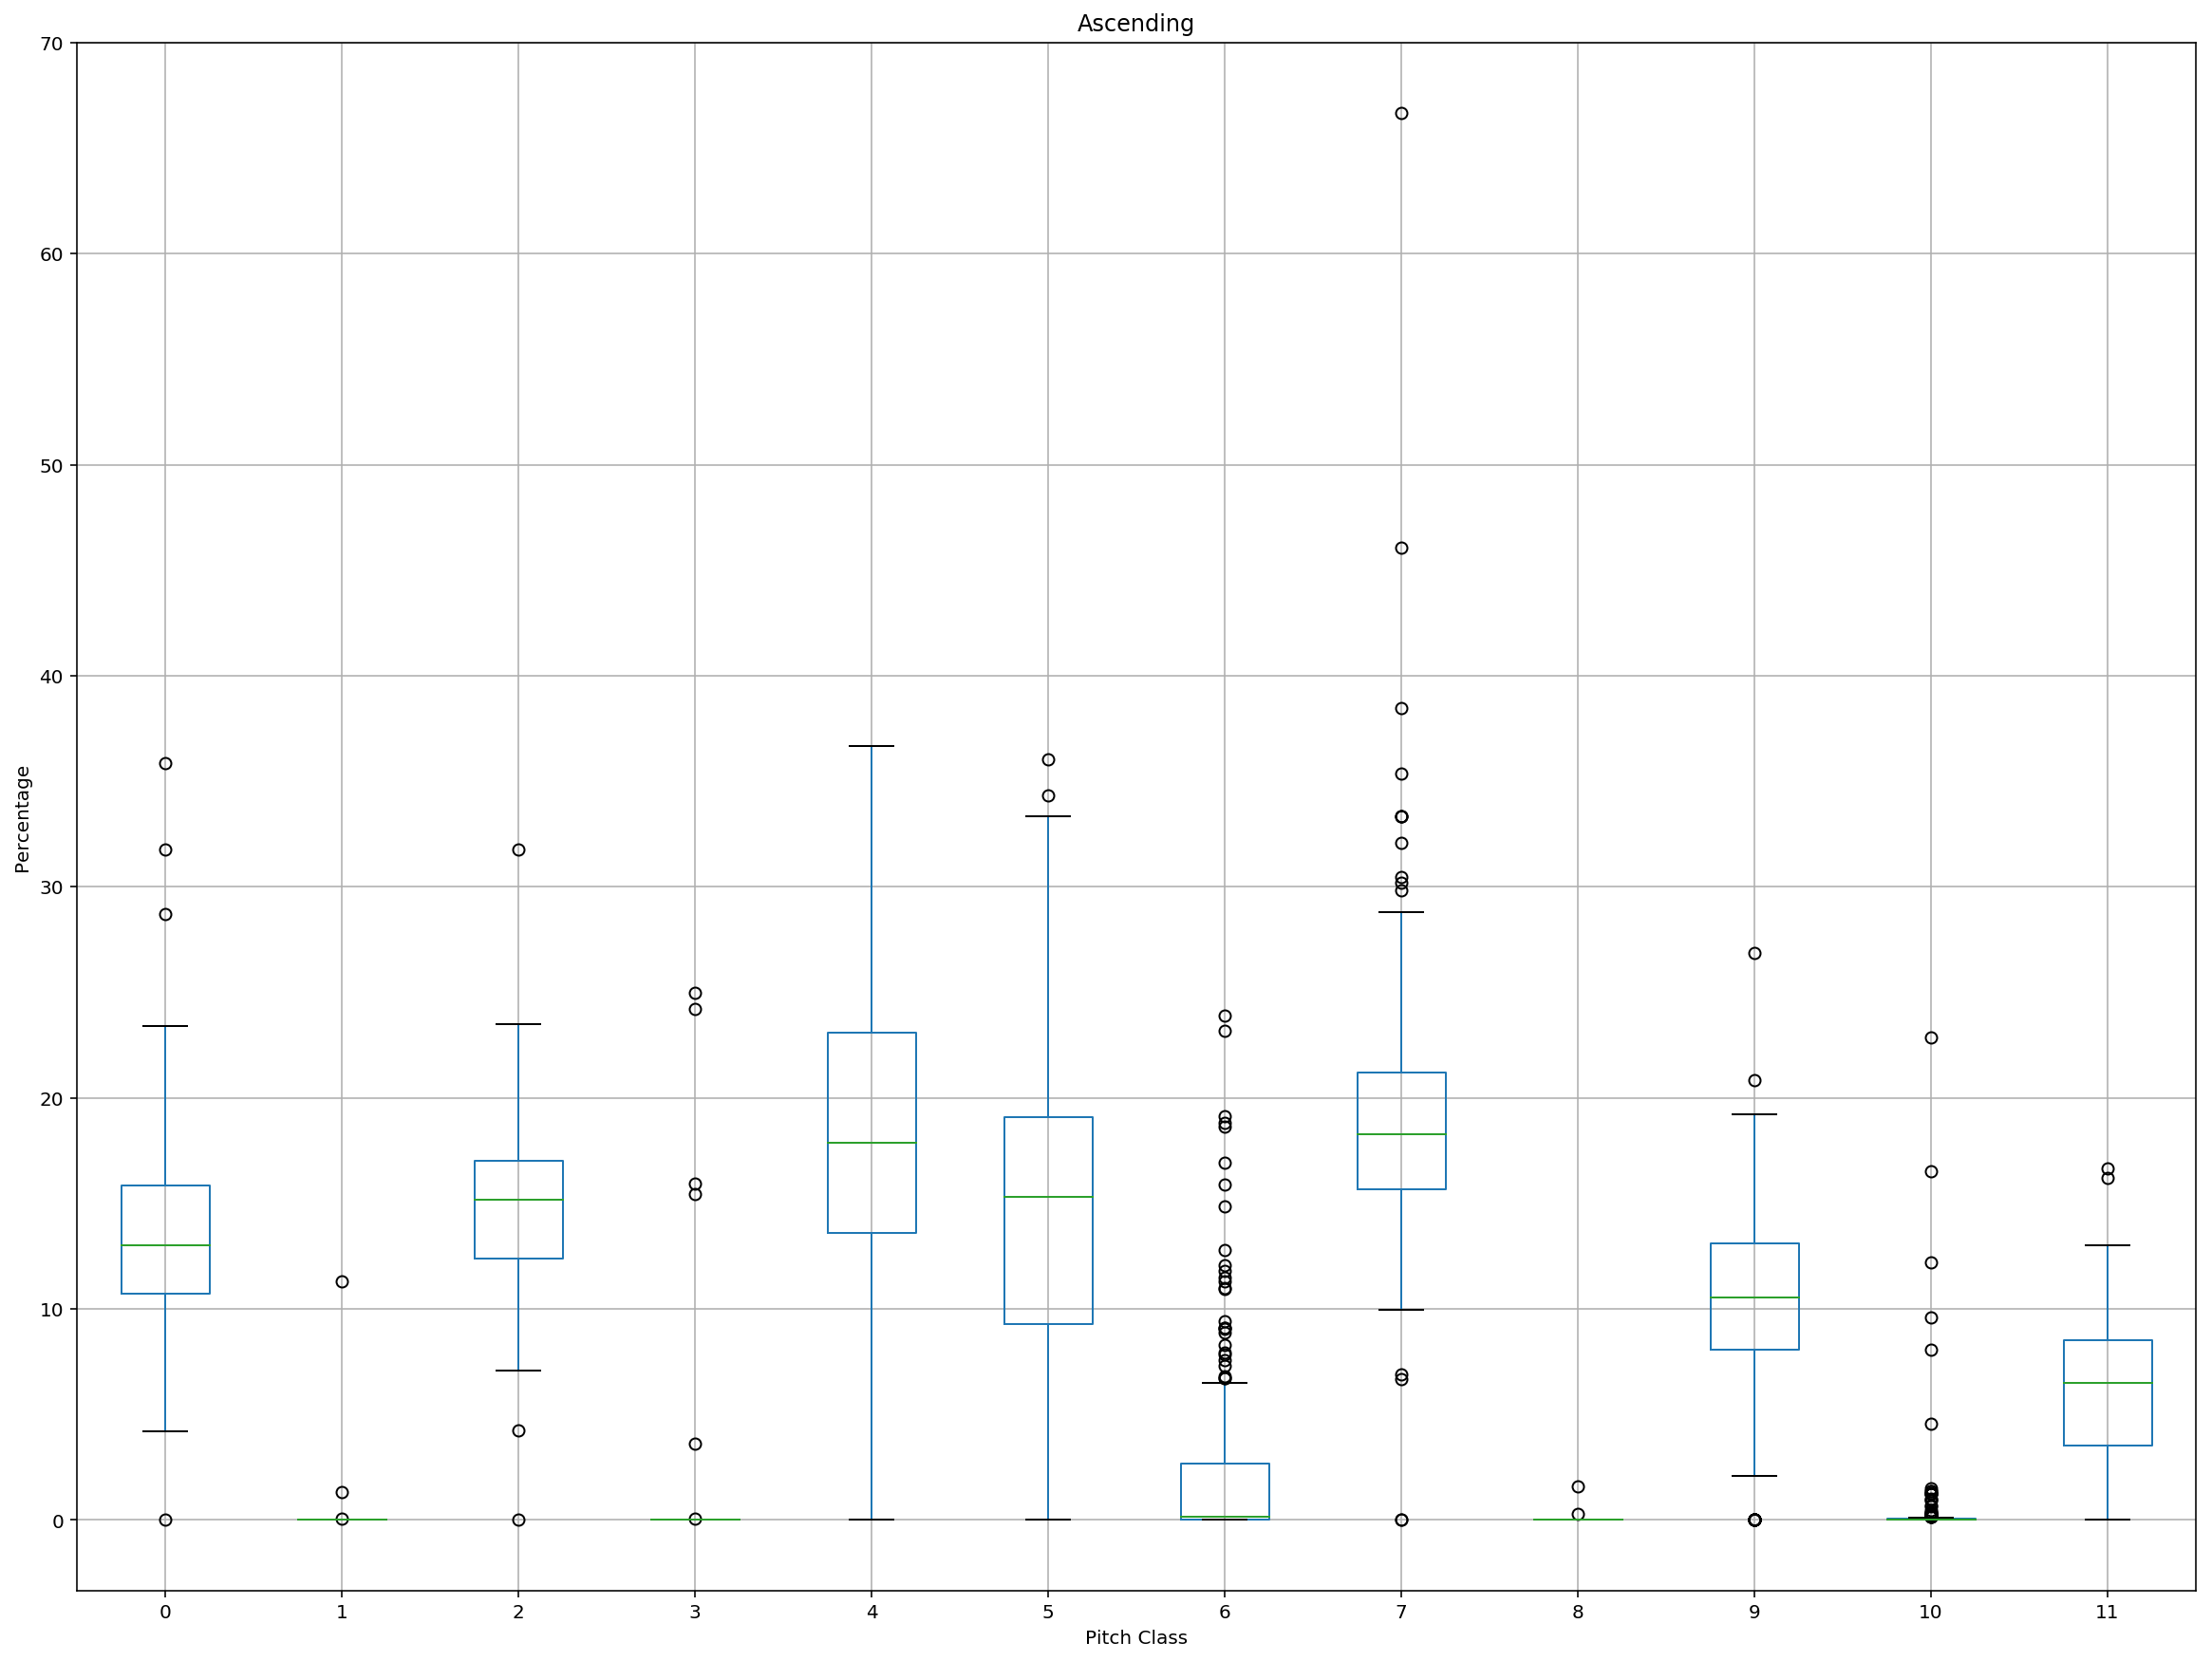

In [7]:
ax = pitchclass_df.boxplot(figsize = (20,15))

plt.xlabel("Pitch Class")
plt.ylabel("Percentage")

if DIRECTION == "asc":
    plt.title("Ascending")
    filename = "Ascending_{0}_distance.png".format(DISTANCE_TH)
    
elif DIRECTION == "desc":
    plt.title("Descending")
    filename = "Descending_{0}_distance.png".format(DISTANCE_TH)
    
plt.savefig(filename)

In [8]:
#print("{0}{1}{2}".format("Formatting files in ", SCORES_DIR, " and storing them in the scores folder..."))

#organize_xml_files(SCORES_DIR)

#print("Done")

In [9]:
#show_music21_settings()